<a href="https://colab.research.google.com/github/TheAcoff/Notebook-Alura/blob/main/Redes_Neurais/CNN_Folhas_de_Videira_Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de folhas de videira
Vamos criar uma rede neural que analiza fotos de folhas de videiras para criarmos um critério de classificação. Primeiro, vamos importar os dados do Google Drive.

## Dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
url = '/content/drive/MyDrive/[4] Estudos/[1] Alura/Dados/CNN/Videiras/uvas'

In [ ]:
import pathlib
data_dir = pathlib.Path(url)
print('Quantidade de fotos: ',len(list(data_dir.glob('*/*.JPG'))))

Quantidade de fotos:  1600


As fotos foram separadas em grupos pré classificados, são eles:

In [ ]:
subfolders = [f.name for f in data_dir.iterdir() if f.is_dir()]
print(subfolders)

['BlackMeasles', 'BlackRot', 'HealthyGrapes', 'LeafBlight']


Visualizando alguns dos dados da pasta BlackMeasles.

In [ ]:
import PIL

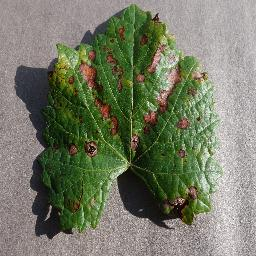

In [ ]:
blackmeasles = list(data_dir.glob('BlackMeasles/*'))
PIL.Image.open(str(blackmeasles[0]))

Os dados são imagens, agora temos que transformar em um dado que possa ser interpretado por uma rede neural. Primeiro, vamos analizar o tamanho das imagens.

In [ ]:
import numpy as np
for subfolder in subfolders:
  path = data_dir / subfolder
  images = list(path.glob('*.JPG'))
  print(f'Classe {subfolder} tem {len(images)} imagens.')

  if images:
    img = PIL.Image.open(str(images[0]))
    img_array = np.array(img)
    print(f'A primeira imagem de {subfolder} tem {img_array.shape} pixels.')

Classe BlackMeasles tem 400 imagens.
A primeira imagem de BlackMeasles tem (256, 256, 3) pixels.
Classe BlackRot tem 400 imagens.
A primeira imagem de BlackRot tem (256, 256, 3) pixels.
Classe HealthyGrapes tem 400 imagens.
A primeira imagem de HealthyGrapes tem (256, 256, 3) pixels.
Classe LeafBlight tem 400 imagens.
A primeira imagem de LeafBlight tem (256, 256, 3) pixels.


É interessante observar que nossa imagem é bidimensional, mas foi nos retornado um tensor rank 3. A explicação para isso é que as duas primeiras entradas correspondem aos pixels da imagem, enquando a terceira entrada o canal de cor.

Agora podemos carregar os dados com o Tensorflow. Para isso, vamos fazer o upload em pequenos pacotes (batches).

In [ ]:
import tensorflow as tf

In [ ]:
batch_size = 126
altura = 256
largura = 256

In [ ]:
treino = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=7331,
    validation_split=0.2,
    subset='training',
    image_size=(altura, largura),
    batch_size=batch_size
)

Found 1600 files belonging to 4 classes.
Using 1280 files for training.


In [ ]:
teste = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=7331,
    validation_split=0.2,
    subset='validation',
    image_size=(altura, largura),
    batch_size=batch_size
)

Found 1600 files belonging to 4 classes.
Using 320 files for validation.


## Rede Neural Perceptron

Começaremos com uma rede neural sem camada convolucional.

In [ ]:
tf.random.set_seed(2151)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

modelo = tf.keras.Sequential([
    layers.Input(shape = (altura, largura, 3)), #Tensor de entrada
    layers.Rescaling(1./255), #Normalização das cores
    layers.Flatten(), #Achatar a imagem
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation = 'softmax')
])

modelo.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 196608)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      50,331,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,332,932 (192.00 MB)

 Trainable params: 50,332,932 (192.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Teste GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Compile param
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()
metrics = ['accuracy']

# Fit Params
batch_size = 64
epochs = 20

modelo.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

historico = modelo.fit(treino,
                       validation_data = teste,
                       epochs = epochs,
                       batch_size = batch_size
                       )

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 493ms/step - accuracy: 0.2646 - loss: 147.4504 - val_accuracy: 0.2313 - val_loss: 40.1383
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 532ms/step - accuracy: 0.3728 - loss: 27.4114 - val_accuracy: 0.5094 - val_loss: 33.3516
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 409ms/step - accuracy: 0.4245 - loss: 28.0050 - val_accuracy: 0.5719 - val_loss: 6.1151
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 445ms/step - accuracy: 0.5863 - loss: 7.0766 - val_accuracy: 0.6062 - val_loss: 5.5932
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step - accuracy: 0.6038 - loss: 6.2707 - val_accuracy: 0.6812 - val_loss: 8.5336
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.6421 - loss: 8.4054 - val_accuracy: 0.6562 - val_loss: 7.8245
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 480ms/step - accuracy: 0.6056 - loss: 6.8154 - val_accuracy: 0.6375 - val_loss: 4.9034
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - accuracy: 0.7011 - loss: 5.2020 - val_accura

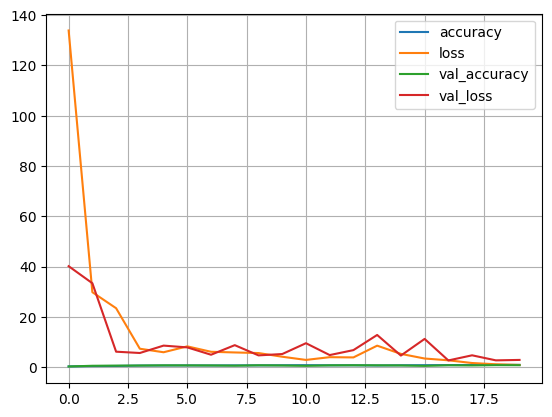

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(historico.history).plot()
plt.grid()
plt.show()

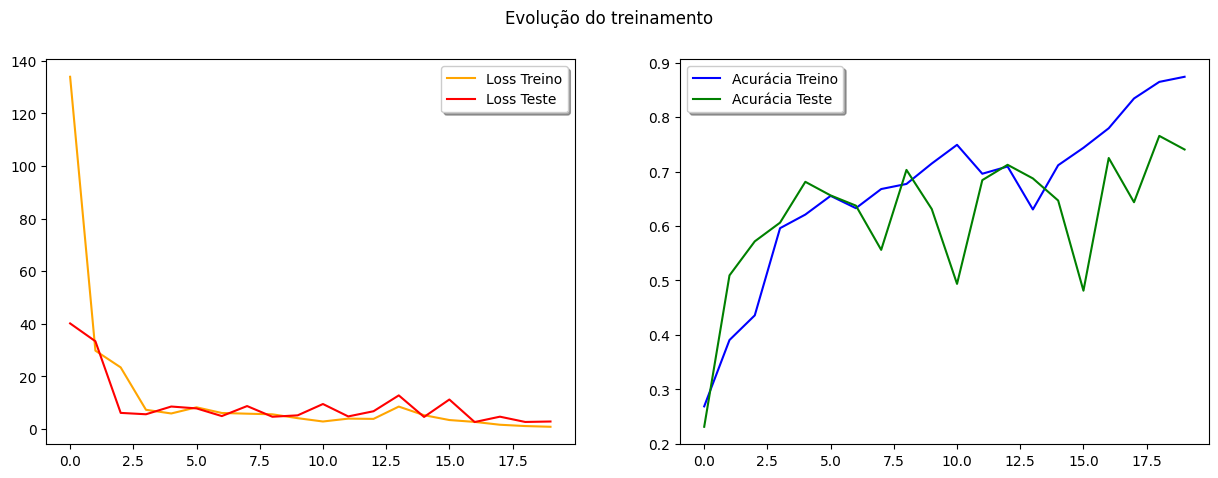

In [ ]:
# Valores separados
fig, ax = plt.subplots(1,2, figsize = (15,5))

plt.suptitle('Evolução do treinamento')

ax[0].plot(historico.history['loss'], color = 'orange', label = 'Loss Treino')
ax[0].plot(historico.history['val_loss'], color = 'red', label = 'Loss Teste')
ax[0].legend(loc = 'best', shadow = True)

ax[1].plot(historico.history['accuracy'], color = 'blue', label = 'Acurácia Treino')
ax[1].plot(historico.history['val_accuracy'], color = 'green', label = 'Acurácia Teste')
ax[1].legend(loc = 'best', shadow = True)

plt.show()